# Fitness assay simulations

In this project, I explore the limitations of inferring gene essentiality from bulk fitness assays such as transposon sequencing approaches ([TnSeq](https://www.nature.com/articles/nmeth.1377), [TraDIS](https://genome.cshlp.org/content/19/12/2308.short), [InSeq](https://www.sciencedirect.com/science/article/pii/S1931312809002819), [HITS](https://www.pnas.org/doi/abs/10.1073/pnas.0906627106)). In these papers, transposons are used to disrupt genes (somewhat randomly), and tracking frequencies of a pool (or library) of these mutants using sequencing as a readout.  Because these approaches involve competing thousands of mutants together, a mutant with a mild fitness defect may appear similar to a mutant in a gene essential for growth (say a gene like RNA Polymerase). 

Here, I simulate fitness assays (grounded in experimental data), and propose an approach for defining a threshold beyond which it is not possible to distinguish deleterious mutations from mutations in essential genes.

### Definitions/Terminology

- Essential gene: here I work with a very strict defition of essentiality. A gene is essential if a cell cannot grow without it. As an example, a 50% reduction in growth rate is not considered essentiality under this strict defition. 
- Neutral gene: a gene which when lost has no impact on cellular growth.
- Deleterious genes: genes which when lost lead to a reduction in growth rate. Note that deleterious genes lie in a continuum between essential genes and neutral genes.
- Fitness: the per-generation log-fold change in frequency of a mutant.

In [1]:
#importing libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from Bio.SeqIO.FastaIO import SimpleFastaParser
import re
import pandas as pd
import seaborn as sns
import pathlib
import os

In [105]:
sns.set_theme()
sns.set_context('paper')
sns.set_style('ticks')

### Loading metadata

In [3]:
#current working directory
cwd = os.getcwd()
print(cwd)

/Users/anuraglimdi/github/2022_Limdi_limits-pooled-fitness-assays/AnalysisNotebooks


In [5]:
#use the pathlib.Path function to get the parent directories-> goal is to navigate to directory with the metadata
# and the fitness trajectories data
path = pathlib.Path(cwd)
repo = str(path.parents[0])
print(path.parents[0]) #this should be the base directory for the github repository: the exact path will differ for 
#each unique user

/Users/anuraglimdi/github/2022_Limdi_limits-pooled-fitness-assays


In [6]:
#paths for metadat and mutant trajectories
metadata_path = repo+'/Metadata/'
data_path = repo+'/ProcessedData/Mutant_Trajectories/'

In [7]:
#names of libraries
libraries = ['REL606']
#more interpretable names for the figures in the paper
libraries2 = ['Anc']

In [8]:
#opening the pandas file with all the metadata!
all_data = pd.read_csv(metadata_path+"all_metadata_REL606.txt", sep="\t")
names = all_data.iloc[:,0]
gene_start = all_data.iloc[:,3]
gene_end = all_data.iloc[:,4]
strand = all_data.iloc[:,5]
locations = np.transpose(np.vstack([gene_start,gene_end,strand]))
k12_tags = all_data.iloc[:,2]
uniprot_rel606 = all_data.iloc[:,6]

#genomic coordinates of pseudogenes
locations_pseudogenes = np.loadtxt(metadata_path+'pseudogenes_locations_REL606.txt')

In [9]:
#fractions of the gene at the 5' and 3' ends to be excluded from analysis because they insertions there may not actually
#be disruptive to protein function
frac5p = 0.1
frac3p = 0.25

#reading the REL606 reference genome
with open(metadata_path+"rel606_reference.fasta") as in_handle:
    for title, seq in SimpleFastaParser(in_handle):
        ta_sites = [m.start(0) for m in re.finditer('TA', seq)]
ta_sites = np.array(ta_sites)

#counting how many TA sites are present in the interior of each gene
ta_gene = np.zeros(len(names))
for i in range(0,len(names)):
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        #counting sites only in the middle of the gene, excluding defined fractions at each end
        ta_gene[i] = np.sum((ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p))
    elif locations[i,2]==-1:
        ta_gene[i] = np.sum((ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p))

### Loading the mutant trajectories data for the LTEE Ancestor

In [14]:
#all the information from the fitness assay condensed into a couple of matrices
counts_all_green = np.zeros([5, len(ta_sites)])
counts_all_red = np.zeros([5, len(ta_sites)])

#loading the new file where I have the counts for each TA site for all time points
gname = data_path+'/green_'+libraries[0]+'_merged_all_TAsites.txt'
greendata = np.loadtxt(gname)
rname = data_path+'/red_'+libraries[0]+'_merged_all_TAsites.txt'
reddata = np.loadtxt(rname)
#now for extracting the UMI corrected counts
counts_all_green = greendata[2:11:2,:]
counts_all_red = reddata[2:11:2,:]

The data is organized as follows:
- each column corresponds to a TA transposon insertion site in the genome
- each row corresponds to a timepoint in the fitness assay (we have a total of 5 timepoints)
- green and red refer to experimental replicates of the fitness assay (they were named as such because I used red and green sharpies to label tubes in the lab)
- the $t_{0}$ timepoint is the same for the two replicates: I took the transposon library from the freezer, extracted DNA from it, and split it into two replicate fitness assays

In [20]:
#number of sequencing reads in the "red" replicate
print('red\t', counts_all_red.sum(axis=1))
#number of sequencing reads in the "red" replicate
print('green\t', counts_all_green.sum(axis=1))

red	 [15071951. 10926749. 15528916. 18645080. 16380071.]
green	 [15071951. 16444999. 12387024. 14560311. 14105362.]


## Mutant trajectories at different sequencing depths

Approach:

- Downsample the fitness assay counts by the same factor across timepoints
- Compare mutant trajectories for the same genes (spanning a range of fitnesses) at different sequencing depths
- Compare the estimated fitness from downsampled data to the "true" fitness (from the highest sequencing depth), and observe how this changes with sequencing depth.

Questions we're exploring:

- Do mutant trajectories for deleterious and essential genes start becoming more similar as sequencing depth decreases? This would start to hint at a key point of the paper: our ability to distinguish deleterious fitness effects gets worse with less sequencing depth
- Is there a point beyond which increasing sequencing depth does not lead to a meaningful improvement in convergence to "true" fitness (while acknowledging that we don't have a ground truth)?

#### Defining some important functions


In [65]:
def downsample(data, scale):
    """
    Inputs: 
    - data: counts matrix for bulk fitness assay
    - scale: scaling factor for downsampling, must be greater than 1.
    
    Process:
    - downsample number of reads mapping to an insertion site as follows (for each time point, here: by row)
    - use np.repeat to get an list with every insertion site repeated N times, where N is the number of mapped reads
    - use np.shuffle to rearrange this list
    - pick the first 1/scale fraction of this list
    - use np.unique to which sites are represented, and how frequently after downsampling.
    
    Output:
    - data_scaled: same shape as data but each row of the matrix downsampled by the scaling factor
    """
    assert scale >= 1, f"downsampling scale factor must be greater than/equal 1"
    
    if scale == 1: #do not downsample the data at all:
        return data
    
    else:
        data_scaled = np.zeros_like(data)

        for t in range(data.shape[0]): #there are 5 timepoints in the data
            #this is the key step in the process, every TA site is repeated as many times as number of reads mapping to it
            explicit_data = np.repeat(np.arange(0,data.shape[1]), data[t,:].astype('int'))
            #this list is then shuffled
            np.random.shuffle(explicit_data)
            #and a subset of this list becomes the new data
            N_ds = int(data.sum(axis=1)[t]/scale)
            #as we shuffled the data, taking the first N_ds reads is equivalent to taking a 1/scale random subset of the data
            downsampled = explicit_data[:N_ds]
            #getting the counts and unique TA sites represented after downsampling
            unique, counts = np.unique(downsampled, return_counts=True)
            data_scaled[t,unique] = counts
        
        return data_scaled

In [66]:
def search_gene(locations,ta_sites,i):
    """
    Input: 
    locations: gene coordinates, start, end and orientation
    ta_sites: list of TA sites
    i: query gene
    
    Returns:
    mask corresponding to the interior of the 'i'th gene in the E. coli genome
    """
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        search_area = (ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p)
    #if the gene is on the reverse strand
    elif locations[i,2]==-1:
        search_area = (ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p)
    return search_area

In [216]:
def construct_dict(trajectory_data):
    """
    Goal of the function is to take the trajectories matrix for a gene and convert it to longform, where each row 
    is a single datapoint.
    Input:
    
    trajectory_data: the normalized frequency data for a gene
    
    Function will add dictionaries to the array in place
    
    Output:     
    array: the list to which we will append a dictionary corresponding to each row

    """
    array = []
    
    for site in range(trajectory_data.shape[0]):
        for t in range(trajectory_data.shape[1]):
            dict1 = {}
            dict1["timepoint"] = t
            dict1["frequency of mutant"] = trajectory_data[site, t]
            array.append(dict1)
            
    return array

In [221]:
def plot_trajectories(data, gene):
    """
    Input
    data: 5x211995 TnSeq counts matrix 
    gene: gene number
    
    Output:
    generate plot of mutant trajectories in the interior of this gene
    
    """
    
    time = np.linspace(0,4,5)
    #extracting counts only for the gene of interest
    gene_data = data[:, search_gene(locations, ta_sites, gene)]
    normalized = gene_data.transpose()/data.sum(axis=1)
    rows = construct_dict(normalized)
    normalized_df = pd.DataFrame(rows)
    print(normalized.shape)
#     for row in range(gene_data.shape[1]):
#         if normalized[row, 0] > 10**-5.5:
#             plt.plot(normalized[row,:])
#     plt.yscale('log')
#     plt.ylabel('Mutant Frequency')
#     plt.xlabel('Time (in days)')
#     sns.despine()
#     plt.show()
    
    with sns.axes_style('ticks'):

        ax = sns.relplot(kind='line',data=normalized_df, x='timepoint',y='frequency of mutant',palette='coolwarm')
        ax.set(yscale="log", xticks=np.linspace(0,4,5), ylabel='number of reads\nper TA site', xlabel='Time (days)')
  
    
    return None
    

In [186]:
def plot_trajectories_sum(data, gene, color):
    """
    Input
    data: 5x211995 TnSeq counts matrix 
    gene: gene number
    
    Output:
    generate plot of mutant trajectories in the interior of this gene
    
    """
    
    time = np.linspace(0,4,5)
    #extracting counts only for the gene of interest
    gene_data = data[:, search_gene(locations, ta_sites, gene)]
    normalized = gene_data.transpose()/data.sum(axis=1)
    plt.plot(time, normalized.sum(axis=0)/normalized.sum(axis=0)[0], '-o', color=color, alpha=0.4)
    plt.yscale('log')
    plt.ylabel('Mutant Frequency')
    plt.xlabel('Time (in days)')
    sns.despine()
    
    return None

In [189]:
green_downsampled = downsample(data=counts_all_green, scale=20)

(69, 5)
(69, 5)


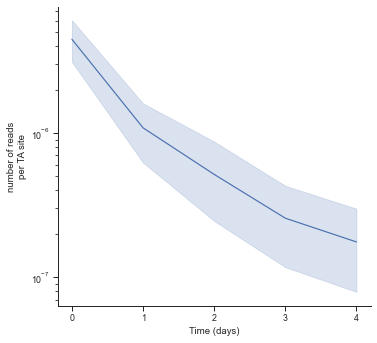

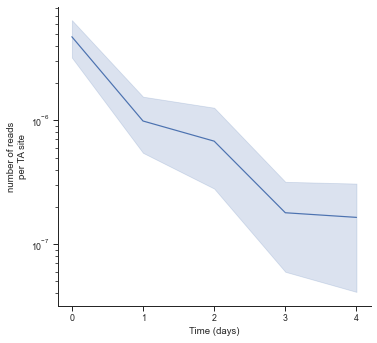

In [223]:
plot_trajectories(counts_all_green, list(names).index('ydiJ'))
plot_trajectories(green_downsampled, list(names).index('ydiJ'))
